In [3]:
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# # Thornton, CO
latitude = 39.903057
longitude = -104.954445
#Ann Arbor
# latitude = 42.2808256
# longitude = -83.7430378
# # Omaha
# latitude = 41.257160
# longitude = -95.995102
# Concord
# latitude =  37.989128
# longitude = -122.043686

In [4]:
def generate_points(lat, lon, num_loc):
    area_dict = {}
    random.seed(12)
    
    for x in range(num_loc):
        lat_change = random.uniform(-1, 1)/2
        lon_change = random.uniform(-1, 1)/2
        area_dict[x] = [lat+lat_change, lon+lon_change]
    return area_dict

In [5]:
area_dict = generate_points(latitude, longitude, 300)

In [8]:
def make_url(area_dict, auth_key):
    lat_long_values = ''
    
    for key, value in area_dict.items():
        if key == 0 or isinstance(key, str):
            lat_long_values += str(value[0]) + '%2C' + str(value[1])
        else:
            lat_long_values += '%7C' + str(value[0]) + '%2C' + str(value[1])
    
    return(f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat_long_values}&key={auth_key}")

In [9]:
epicenter = {}
epicenter[0] = [latitude, longitude]
epicenter_url = make_url(epicenter, '<key>')

In [10]:
url = make_url(area_dict, '<key>')

In [11]:
response = requests.get(url)
json_data = response.json()

In [12]:
response_2 = requests.get(epicenter_url)
json_data_2 = response_2.json()

In [13]:
epicenter_data = json_data_2['results'][0]

In [14]:
print(epicenter_data)

{'elevation': 1599.578491210938, 'location': {'lat': 39.903057, 'lng': -104.954445}, 'resolution': 4.771975994110107}


In [15]:
epicenter_elevation = epicenter_data['elevation']

In [16]:
df= pd.DataFrame(json_data['results'])

In [17]:
print(df['location'][0].values())

dict_values([39.87762767868855, -104.7969724973428])


In [18]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [19]:
def dist_from_epi():
    global latitude
    global longitude
    global area_dict
    
    hav_dist_list = []
    
    for x in range(len(area_dict)):
        hav_dist_list.append(haversine(longitude, latitude, area_dict[x][1], area_dict[x][0]))
   
    return pd.DataFrame(hav_dist_list)


In [20]:
df2 = dist_from_epi()

In [21]:
df['haver_dist_from_epi'] = df2*1000 #keep measures consistent (meters)

In [22]:
print(df.head())

     elevation                                           location  resolution  \
0  1572.958130  {'lat': 39.87762767868855, 'lng': -104.7969724...  152.703232   
1  1879.926758  {'lat': 40.06946747112484, 'lng': -105.3118446...  305.406464   
2  2094.060791  {'lat': 39.41391744309006, 'lng': -105.0796905...  152.703232   
3  1759.011353  {'lat': 39.67710513947833, 'lng': -104.6440969...  305.406464   
4  1499.167969  {'lat': 40.09364965303868, 'lng': -104.8529879...  152.703232   

   haver_dist_from_epi  
0         13729.395404  
1         35630.995762  
2         55436.497032  
3         36529.141001  
4         22887.342407  


In [23]:
df['el_over_dist_ratio'] = (abs(df['elevation'] - epicenter_elevation)/df['haver_dist_from_epi'])

In [24]:
df['elevation_diff'] = abs(df['elevation'] - epicenter_elevation)

In [27]:
print(df)

       elevation                                           location  \
0    1572.958130  {'lat': 39.87762767868855, 'lng': -104.7969724...   
1    1879.926758  {'lat': 40.06946747112484, 'lng': -105.3118446...   
2    2094.060791  {'lat': 39.41391744309006, 'lng': -105.0796905...   
3    1759.011353  {'lat': 39.67710513947833, 'lng': -104.6440969...   
4    1499.167969  {'lat': 40.09364965303868, 'lng': -104.8529879...   
..           ...                                                ...   
295  1635.449829  {'lat': 39.83695914186348, 'lng': -105.0628073...   
296  1802.043945  {'lat': 39.60345024588248, 'lng': -104.4915811...   
297  1433.178711  {'lat': 40.31666773084797, 'lng': -104.8043597...   
298  2000.032471  {'lat': 40.05315557399128, 'lng': -105.3103463...   
299  2049.147705  {'lat': 39.94455744695547, 'lng': -105.2874664...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  
0    152.703232         13729.395404            0.001939       26.620361

Simple method:

Calculate the haversine distance between the randomly generated points and the coordinates used to derive the points. Then, take the absolute value of the elevation difference and divide that by haversine distance to get an elevation change/distance ratio.


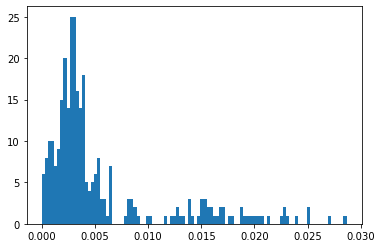

In [25]:
plt.hist(x=df['el_over_dist_ratio'], bins=100)
plt.show()

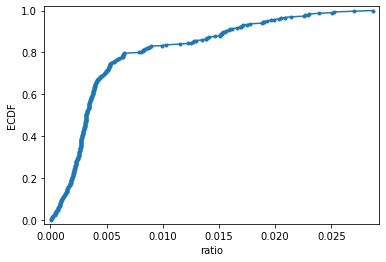

In [28]:
x = np.sort(df['el_over_dist_ratio'])
y = np.arange(1, len(x)+1) / len(x)

plt.plot(x, y, marker='.', linestyle=None)
plt.xlabel('ratio')
plt.ylabel('ECDF')

plt.margins(0.02) # keeps data off plot edges
plt.show()

In [297]:
df.to_csv('concord_ca_elevation.csv') #This has been done to all locations

In [29]:
ann_arbor_df = pd.read_csv('ann_arbor_mi_elevation.csv')

In [30]:
print(ann_arbor_df)

      elevation                                           location  \
0    231.850159  {'lat': 42.25539627868855, 'lng': -83.58556529...   
1    289.423584  {'lat': 42.44723607112484, 'lng': -84.10043744...   
2    214.254807  {'lat': 41.79168604309007, 'lng': -83.86828330...   
3    189.908356  {'lat': 42.05487373947833, 'lng': -83.43268974...   
4    292.249695  {'lat': 42.47141825303869, 'lng': -83.64158076...   
..          ...                                                ...   
295  284.113556  {'lat': 42.21472774186348, 'lng': -83.85140018...   
296  177.071579  {'lat': 41.98121884588248, 'lng': -83.28017392...   
297  336.319611  {'lat': 42.69443633084796, 'lng': -83.59295252...   
298  276.723144  {'lat': 42.43092417399129, 'lng': -84.09893918...   
299  295.210663  {'lat': 42.32232604695547, 'lng': -84.07605921...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  
0    305.406464          13262.53430            0.002386       31.642670  
1    305.

In [31]:
thornton_df = pd.read_csv('thornton_co_elevation.csv')

In [32]:
print(thornton_df)

       elevation                                           location  \
0    1572.958130  {'lat': 39.87762767868855, 'lng': -104.7969724...   
1    1879.926758  {'lat': 40.06946747112484, 'lng': -105.3118446...   
2    2094.060791  {'lat': 39.41391744309006, 'lng': -105.0796905...   
3    1759.011353  {'lat': 39.67710513947833, 'lng': -104.6440969...   
4    1499.167969  {'lat': 40.09364965303868, 'lng': -104.8529879...   
..           ...                                                ...   
295  1635.449829  {'lat': 39.83695914186348, 'lng': -105.0628073...   
296  1802.043945  {'lat': 39.60345024588248, 'lng': -104.4915811...   
297  1433.178711  {'lat': 40.31666773084797, 'lng': -104.8043597...   
298  2000.032471  {'lat': 40.05315557399128, 'lng': -105.3103463...   
299  2049.147705  {'lat': 39.94455744695547, 'lng': -105.2874664...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  
0    152.703232          13729.39540            0.001939       26.620361

In [33]:
omaha_df = pd.read_csv('omaha_ne_elevation.csv')
print(omaha_df)

      elevation                                           location  \
0    298.177948  {'lat': 41.23173067868855, 'lng': -95.83762949...   
1    349.758514  {'lat': 41.42357047112484, 'lng': -96.35250164...   
2    373.393341  {'lat': 40.76802044309007, 'lng': -96.12034750...   
3    382.474335  {'lat': 41.03120813947833, 'lng': -95.68475394...   
4    301.699585  {'lat': 41.44775265303868, 'lng': -95.89364496...   
..          ...                                                ...   
295  316.874664  {'lat': 41.19106214186348, 'lng': -96.10346438...   
296  310.387451  {'lat': 40.95755324588248, 'lng': -95.53223812...   
297  324.661041  {'lat': 41.67077073084796, 'lng': -95.84501672...   
298  348.626434  {'lat': 41.40725857399129, 'lng': -96.35100338...   
299  345.186432  {'lat': 41.29866044695547, 'lng': -96.32812341...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  
0    305.406464          13466.15610            0.004540       61.132477  
1    305.

In [34]:
concord_df = pd.read_csv('concord_ca_elevation.csv')
print(concord_df)

      elevation                                           location  \
0    240.822082  {'lat': 37.96369867868855, 'lng': -121.8862134...   
1      1.529585  {'lat': 38.15553847112484, 'lng': -122.4010856...   
2      2.259292  {'lat': 37.49998844309007, 'lng': -122.1689315...   
3    309.525543  {'lat': 37.76317613947833, 'lng': -121.7333379...   
4      0.665573  {'lat': 38.17972065303869, 'lng': -121.9422289...   
..          ...                                                ...   
295  317.618744  {'lat': 37.92303014186349, 'lng': -122.1520483...   
296  301.287231  {'lat': 37.68952124588248, 'lng': -121.5808221...   
297   20.436710  {'lat': 38.40273873084797, 'lng': -121.8936007...   
298    0.305499  {'lat': 38.13922657399128, 'lng': -122.3995873...   
299  -12.325742  {'lat': 38.03062844695548, 'lng': -122.3767074...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  
0    305.406464          14089.27238            0.016308      229.771611  
1    305.

In [39]:
thornton_df['tag'] = 'thornton'
concord_df['tag'] = 'concord'
ann_arbor_df['tag'] = 'ann arbor'
omaha_df['tag'] = 'omaha'


In [40]:
all_4_df = pd.concat([thornton_df, ann_arbor_df, omaha_df, concord_df])

In [41]:
print(all_4_df)

       elevation                                           location  \
0    1572.958130  {'lat': 39.87762767868855, 'lng': -104.7969724...   
1    1879.926758  {'lat': 40.06946747112484, 'lng': -105.3118446...   
2    2094.060791  {'lat': 39.41391744309006, 'lng': -105.0796905...   
3    1759.011353  {'lat': 39.67710513947833, 'lng': -104.6440969...   
4    1499.167969  {'lat': 40.09364965303868, 'lng': -104.8529879...   
..           ...                                                ...   
295   317.618744  {'lat': 37.92303014186349, 'lng': -122.1520483...   
296   301.287231  {'lat': 37.68952124588248, 'lng': -121.5808221...   
297    20.436710  {'lat': 38.40273873084797, 'lng': -121.8936007...   
298     0.305499  {'lat': 38.13922657399128, 'lng': -122.3995873...   
299   -12.325742  {'lat': 38.03062844695548, 'lng': -122.3767074...   

     resolution  haver_dist_from_epi  el_over_dist_ratio  elevation_diff  \
0    152.703232          13729.39540            0.001939       26.62036

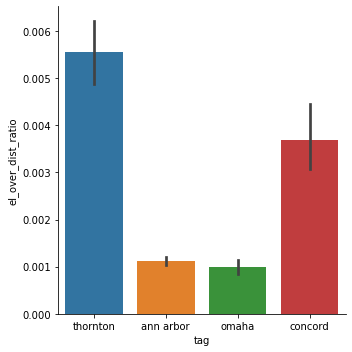

In [42]:
sns.catplot(x='tag', y='el_over_dist_ratio', kind='bar', data=all_4_df)
plt.show()

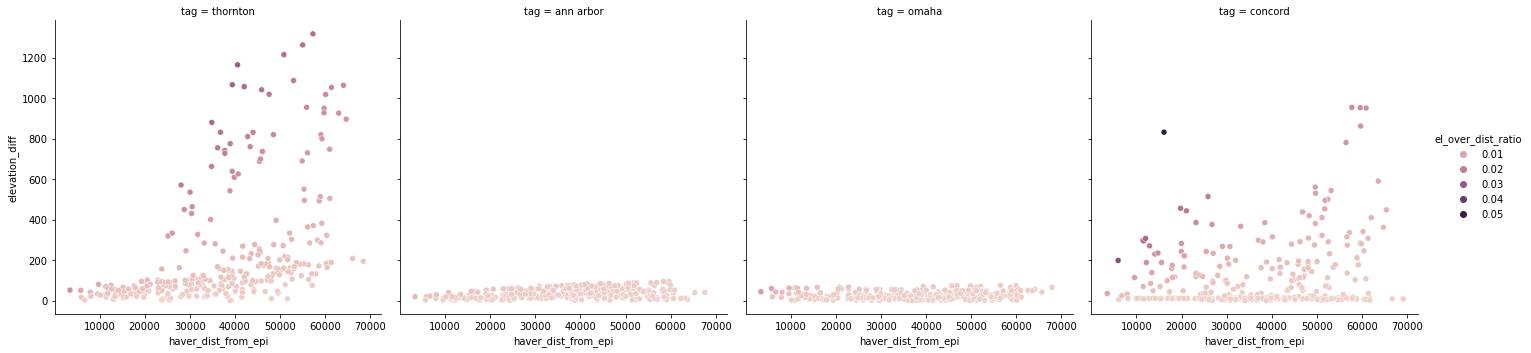

In [43]:
# fig, ax = plt.subplots(figsize=(8, 8))

sns.relplot(x='haver_dist_from_epi', y='elevation_diff', hue='el_over_dist_ratio', col='tag', data=all_4_df)
plt.show()

In [44]:
pd.pivot_table(all_4_df, index='tag')

,el_over_dist_ratio,elevation,elevation_diff,haver_dist_from_epi,resolution
tag,,,,,
ann arbor,0.001126,255.018827,37.790843,36633.166193,260.104505
concord,0.003696,119.798200,117.677544,37476.298178,320.676787
omaha,0.000988,349.082230,27.108759,36839.087302,322.712830
thornton,0.005554,1752.476045,226.387386,37107.000944,222.946718


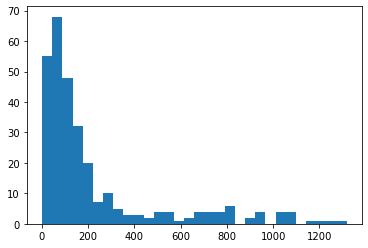

In [50]:
plt.hist(x=all_4_df[all_4_df['tag'] == 'thornton']['elevation_diff'] , bins=30)
plt.show()

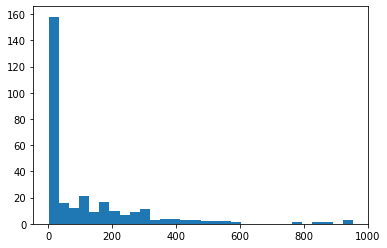

In [51]:
plt.hist(x=all_4_df[all_4_df['tag'] == 'concord']['elevation_diff'] , bins=30)
plt.show()

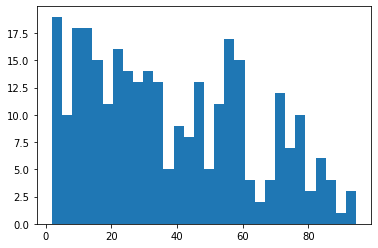

In [52]:
plt.hist(x=all_4_df[all_4_df['tag'] == 'ann arbor']['elevation_diff'] , bins=30)
plt.show()

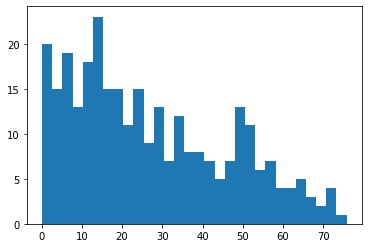

In [53]:
plt.hist(x=all_4_df[all_4_df['tag'] == 'omaha']['elevation_diff'] , bins=30)
plt.show()

Note: The selection of the coordinates does not exclude bodies of water. This issue isnt so much a problem with the selected locations(average distance from location is ~20-25 miles), but I imagine it would cause problems with coastal locations.